#Functions and imports

**Installing dependencies**

*Run these cells if this is the first time that this notebook is being executed.*

In [ ]:
#pip install pysindy

In [ ]:
pip install numpy==1.26.4

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
from scipy.integrate import solve_ivp, odeint
import pysindy as ps
from pysindy.differentiation import FiniteDifference
import pandas as pd
import itertools
import matplotlib.pyplot as plt

np.random.seed(100)

#Error eval
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from scipy import stats

#Extra optimizer
from sklearn.linear_model import OrthogonalMatchingPursuit

#Danger zone:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/home/llober/.local/srenv/lib/python3.13/site-packages/pysindy/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


##Definitions

In [ ]:
def eval_kuramoto(model, sol_kuramoto):
  dtheta_dt = model.predict(sol_kuramoto)

  y_pred = np.array(list(itertools.chain(*model.predict(dtheta_dt))))
  y_true = np.array(list(itertools.chain(*sol_kuramoto)))

  return y_pred, y_true

All structures below are quite similar, but we need to have a cell for each dynamics to take the equations into consideration correctly.

In [ ]:
def volterra(t, y, a=2, b=0.5, c=1, d=0.375):
  u,v = y
  dudt = a*u - b*u*v
  dvdt = -c*v + d*b*u*v

  return [dudt, dvdt]

def eval_volterra(model, ivp_sol, x0):
  y_pred = model.simulate(x0, t=ivp_sol.t)
  y_pred = np.array(list(itertools.chain(*y_pred)))

  #Calculate for the original dynamics
  y_true = volterra([0], ivp_sol.y)    #t=[0] as we don't really need it here.
  y_true = np.array(list(itertools.chain(*y_true)))

  return y_pred, y_true

In [ ]:
def pendulum(t, y):
    theta, omega = y
    g = 9.81
    L = 1.0

    d_theta = omega
    d_omega = - (g / L) * np.sin(theta)
    return [d_theta, d_omega]

def eval_pendulum(model, ivp_sol, x0):
  y_pred = model.simulate(x0, t=ivp_sol.t)
  y_pred = np.array(list(itertools.chain(*y_pred)))

  #Calculate for the original dynamics
  y_true = pendulum([0], ivp_sol.y)    #t=[0] as we don't really need it here.
  y_true = np.array(list(itertools.chain(*y_true)))

  return y_pred, y_true

In [ ]:
def lorenz(t, ivp_sol, sigma=2.0, rho=1.0, beta=2.6):
  x, y, z = ivp_sol
  dx_dt = sigma * (y - x)
  dy_dt = x * (rho - z) - y
  dz_dt = x * y - beta * z

  return [dx_dt, dy_dt, dz_dt]

def eval_lorenz(model, ivp_sol, x0):
  y_pred = model.simulate(x0, t=ivp_sol.t)
  y_pred = np.array(list(itertools.chain(*y_pred)))

  #Calculate for the original dynamics
  y_true = lorenz([0], ivp_sol.y)    #t=[0] as we don't really need it here.
  y_true = np.array(list(itertools.chain(*y_true)))

  return y_pred, y_true

In [ ]:
#=== SIS ===
def sis(t, y, beta = 0.3, gamma = 0.1):
  S, I = y
  dSdt = -beta * S * I + gamma * I
  dIdt = beta * S * I - gamma * I
  return [dSdt, dIdt]

def eval_SIS(model, ivp_sol, x0):
  #Done with the way the SINDy model outputs the parameters in mind
  y_pred = model.simulate(x0, t=ivp_sol.t)
  y_pred = np.array(list(itertools.chain(*y_pred)))

  #Calculate for the original dynamics
  y_true = sis([0], ivp_sol.y)    #t=[0] as we don't really need it here.
  y_true = np.array(list(itertools.chain(*y_true)))

  return y_pred, y_true

In [ ]:
#=== SIR ===
def sir(t, y, beta=0.3, gamma=0.1):
  S, I, R = y
  dSdt = -beta * S * I
  dIdt = beta * S * I - gamma * I
  dRdt = gamma*I
  return [dSdt, dIdt, dRdt]

def eval_SIR(model, ivp_sol, x0):
  #Done with the way the SINDy model outputs the parameters in mind
  y_pred = model.simulate(x0, t=ivp_sol.t)
  y_pred = np.array(list(itertools.chain(*y_pred)))

  #Calculate for the original dynamics
  y_true = sir([0], ivp_sol.y)    #t=[0] as we don't really need it here.
  y_true = np.array(list(itertools.chain(*y_true)))

  return y_pred, y_true

In [ ]:
#=== SEIR ===
def seir(t, y, beta=0.3, alpha=0.2, gamma=1.0):
    S, E, I, R = y
    dSdt = -beta * S * I
    dEdt = beta * S * I - alpha * E
    dIdt = alpha * E - gamma * I
    dRdt = gamma * I
    return [dSdt, dEdt, dIdt, dRdt]

def eval_SEIR(model, ivp_sol, x0):

  #Estimate the variations
  #Done with the way the SINDy model outputs the parameters in mind
  y_pred = model.simulate(x0, t=ivp_sol.t)
  y_pred = np.array(list(itertools.chain(*y_pred)))

  #Calculate for the original dynamics
  y_true = seir([0], ivp_sol.y)    #t=[0] as we don't really need it here.
  y_true = np.array(list(itertools.chain(*y_true)))

  return y_pred, y_true

In [ ]:
 #=== SEIRD ===
def seird(t, y, beta=0.3, alpha=0.2, gamma=1.0, mu=0.1):
    S, E, I, R, D = y
    dSdt = -beta * S * I
    dEdt = beta * S * I - alpha * E
    dIdt = alpha * E - (gamma + mu) * I
    dRdt = gamma * I
    dDdt = mu * I
    return [dSdt, dEdt, dIdt, dRdt, dDdt]

def eval_SEIRD(model, ivp_sol, x0):
  #Estimate the variations
  #Done with the way the SINDy model outputs the parameters in mind
  y_pred = model.simulate(x0, t=ivp_sol.t)
  y_pred = np.array(list(itertools.chain(*y_pred)))

  #Calculate for the original dynamics
  y_true = seird([0], ivp_sol.y)    #t=[0] as we don't really need it here.
  y_true = np.array(list(itertools.chain(*y_true)))

  return y_pred, y_true

In [ ]:
 #=== SIRV ===
def sirv(t, y, beta=0.5, gamma=1.0, nu=0.5):
    S, I, R, V = y
    dSdt = -beta * S * I - nu * S
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I
    dVdt = nu * S
    return [dSdt, dIdt, dRdt, dVdt]

def eval_SIRV(model, ivp_sol, x0):
  #Estimate the variations
  #Done with the way the SINDy model outputs the parameters in mind
  y_pred = model.simulate(x0, t=ivp_sol.t)
  y_pred = np.array(list(itertools.chain(*y_pred)))

  #Calculate for the original dynamics
  y_true = sirv([0], ivp_sol.y)    #t=[0] as we don't really need it here.
  y_true = np.array(list(itertools.chain(*y_true)))

  return y_pred, y_true

In [ ]:
 #=== SIRS ===
def sirs(t, y, beta=0.3, gamma=1.0, nu=0.2):
    S, I, R = y
    dSdt = -beta * S * I + nu * R
    dIdt =  beta * S * I - gamma * I
    dRdt = gamma * I- nu * R
    return [dSdt, dIdt, dRdt]

def eval_SIRS(model, ivp_sol, x0):
  y_true = pd.DataFrame(ivp_sol.y).transpose()
  y_pred = pd.DataFrame(model.simulate(x0, t=ivp_sol.t))

  return y_pred, y_true

##Error evaluation

In [ ]:
def error_eval(model, dyn_name, curves_names, init_params, ivp_sol, y_true, y_pred):
  '''
  This function assumes you've run one of the eval_models() functions previously
  to estimate y_true and y_pred to keep it compatible with all dynamics.
  '''

  #Metrics
  mse = []
  mae = []
  r2 = []
  rmse = []
  statistics = []
  p_values = []
  wilcoxon_sol = []

  y_int = model.simulate(init_params, ivp_sol.t)
  ivp_sol_y = ivp_sol.y.T
  len_sol = ivp_sol_y.shape[1]

  for i in range(len_sol):
    mse.append(mean_squared_error(ivp_sol_y[:, i], y_int[:, i]))
    mae.append(mean_absolute_error(ivp_sol_y[:, i], y_int[:, i]))
    if (r2_score(ivp_sol_y[:, i], y_int[:, i]) < 0):
      r2.append(0)
    else:
      r2.append(r2_score(ivp_sol_y[:, i], y_int[:, i]))
    rmse.append(np.sqrt(mean_squared_error(ivp_sol_y[:, i], y_int[:, i])))

    #Wilcoxon test
    if np.allclose(ivp_sol_y[:, i], y_int[:, i], rtol=1e-5, atol=1e-8):
      stat, p_value = 0.0, 1.0
    else:
      try:
        stat, p_value = stats.wilcoxon(ivp_sol_y[:, i], y_int[:, i], zero_method="pratt")# stats.wilcoxon(y_true, y_pred)
      except ValueError:
        stat, p_value = np.nan, 1.0

    statistics.append(stat)
    p_values.append(p_value)
    wilcoxon_sol.append(1 if p_value < 0.05 else 0)


  res = pd.DataFrame(data={'dynamics': np.repeat(dyn_name,len_sol), 'axis': curves_names,
                           'mae': mae, 'mse': mse, 'r2': r2, 'rmse':rmse,
                           'wilcoxon_raw_value': statistics,
                           'p-value': p_values,
                           'is_difference': wilcoxon_sol})

  return res

#Dynamics to investigate

##Lorenz

In [ ]:
#Parameters
feature_names = ['X', 'Y', 'Z']
t_start = 0.0
t_end = 5.0
t_step = 0.002
t_eval = np.arange(t_start, t_end, t_step)
t_span = (t_start, t_end)
x0, y0, z0 = 0.6, 2.0, 1.0  # Condições iniciais
state0 = [x0, y0, z0]

In [ ]:
#Solve the system
solution = solve_ivp(lorenz, t_span, state0, method='RK45', t_eval=t_eval)

In [ ]:
#Applies SINDy to the dynamics

#--- Functions to use ---
library_functions = [lambda x: x, lambda x,y: x*y ]
library_function_names = [lambda x: x,lambda x,y: x+y]
feature_library= ps.CustomLibrary(library_functions=library_functions,
                                  function_names=library_function_names).fit(solution.y.T)
feature_library.transform(solution.y.T)
feature_library.get_feature_names()

#---Diferentiation and optimizer methods ---
library = ps.PolynomialLibrary(degree=2)  # Escolha a biblioteca de funções
optimizer = ps.STLSQ(threshold=0.2, alpha=1e-4, normalize_columns=False)
#optimizer=OrthogonalMatchingPursuit(n_nonzero_coefs=1)
model = ps.SINDy(optimizer=optimizer, feature_library=feature_library)

#--- Fit the model ---
model.fit(solution.y.T, t=t_step)
model.print()

(x0)' = -2.001 x0 + 2.001 x1
(x1)' = 1.002 x0 + -1.001 x1 + -1.002 x0x2
(x2)' = -2.609 x2 + 1.005 x0x1


In [ ]:
y_pred, y_true = eval_lorenz(model, solution, state0)

res = error_eval(model, 'Lorenz', feature_names, init_params=state0, ivp_sol=solution,
                 y_true=y_true, y_pred=y_pred)
res

,dynamics,axis,mae,mse,r2,rmse,wilcoxon_raw_value,p-value,is_difference
0,Lorenz,X,0.000131,2.323372e-08,1.0,0.000152,797273.0,6.578471e-100,1
1,Lorenz,Y,0.000118,2.355324e-08,1.0,0.000153,642265.0,1.452536e-143,1
2,Lorenz,Z,0.000081,1.255634e-08,1.0,0.000112,1082944.0,2.218841e-40,1


##Lotka-Volterra

In [ ]:
#Parameters
feature_names = ['u', 'v']

t_start = 0.0
t_end = 7.5
t_step = 0.1
t_eval = np.arange(t_start, t_end, t_step)
t_span = (t_start, t_end)
state0 = np.array([20, 5])

In [ ]:
#Solve the system
solution = solve_ivp(volterra, t_span, state0, t_eval=t_eval)

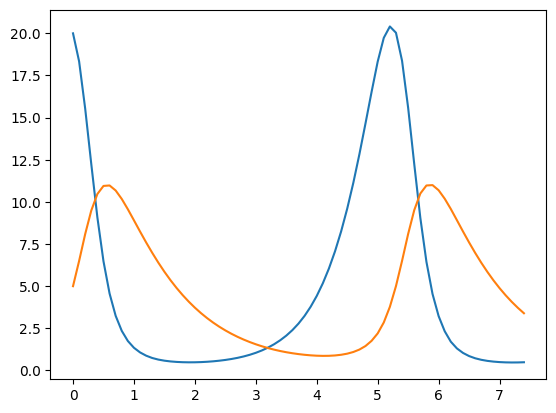

In [ ]:
plt.plot(t_eval,solution.y[0])
plt.plot(t_eval,solution.y[1])

In [ ]:
#Applies SINDy to the dynamics

#--- Functions to use ---
feature_library = ps.PolynomialLibrary(degree=3, include_bias=False )

#---Diferentiation and optimizer methods ---
optimizer = ps.SR3(threshold=0.2 , nu=1 , tol=1e-5)
model = ps.SINDy(optimizer=optimizer, feature_library=feature_library,
                 feature_names=feature_names)

#--- Fit the model ---
model.fit(solution.y.T, t=t_step)
model.print()

(u)' = 1.959 u + -0.491 u v
(v)' = -0.987 v + 0.185 u v


In [ ]:
y_pred, y_true = eval_volterra(model, solution, state0)

res = error_eval(model, 'Lotka-Volterra', feature_names, init_params=state0, ivp_sol=solution,
                 y_true=y_true, y_pred=y_pred)

In [ ]:
res

,dynamics,axis,mae,mse,r2,rmse,wilcoxon_raw_value,p-value,is_difference
0,Lotka-Volterra,u,0.477928,0.772234,0.980009,0.878768,1335.0,0.634609,0
1,Lotka-Volterra,v,0.273705,0.197640,0.983351,0.444567,889.0,0.004688,1


##Simple pendulum

In [ ]:
#Parameters
feature_names = ['theta', 'omega']

t_start = 0.0
t_end = 10
t_step = 0.01
t_eval = np.arange(t_start, t_end, t_step)
t_span = (t_start, t_end)
state0 = np.array([np.radians(45), 0])

In [ ]:
#Solve the system
solution = solve_ivp(pendulum, t_span, state0, t_eval=t_eval)

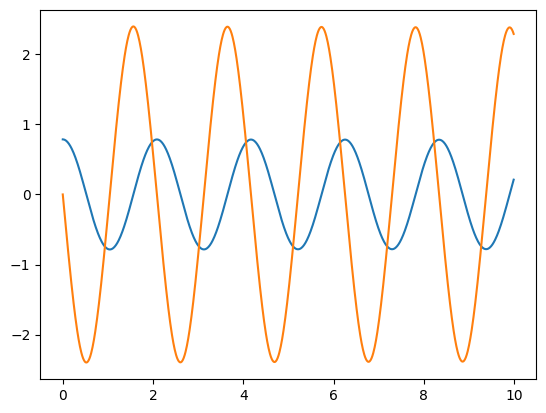

In [ ]:
plt.plot(t_eval,solution.y[0])
plt.plot(t_eval,solution.y[1])

In [ ]:
#Applies SINDy to the dynamics

#--- Functions to use ---
fourier_library=ps.FourierLibrary(n_frequencies = 1)+ps.PolynomialLibrary(degree=1)

#---Diferentiation and optimizer methods ---
optimizer = ps.SR3(threshold=0.4, thresholder='l1', tol=1e-5)
model = ps.SINDy(optimizer=optimizer, feature_library=fourier_library)

#--- Fit the model ---
model.fit(solution.y.T, t=t_step)
model.print()

(x0)' = 1.000 x1
(x1)' = -9.819 sin(1 x0)


In [ ]:
y_pred, y_true = eval_pendulum(model, solution, state0)

res = error_eval(model, 'Simple pendulum', feature_names, init_params=state0, ivp_sol=solution,
                 y_true=y_true, y_pred=y_pred)

In [ ]:
res

,dynamics,axis,mae,mse,r2,rmse,wilcoxon_raw_value,p-value,is_difference
0,Simple pendulum,theta,0.002951,0.000017,0.999944,0.004127,231276.0,0.037812,1
1,Simple pendulum,omega,0.008490,0.000136,0.999952,0.011678,234970.0,0.094420,0


##SIR

In [ ]:
#Parameters
feature_names = ['S', 'I', 'R']
#Time
t_start = 0.0
t_end = 100.0
t_step =  0.002
t_span = (t_start, t_end)
t_eval = np.arange(t_start, t_end, t_step)

N = 1
I0, R0 = 0.001, 0.0
S0 = N - I0 - R0
x0 = np.array([S0, I0, R0])

#They're hardcoded in the SIR function definition. Just stating them here for reference
beta=0.3
gamma=0.1

In [ ]:
#Solve the SIR system
solution = solve_ivp(sir, t_span, x0, t_eval=t_eval)

In [ ]:
#Applies SINDy to the dynamics

#--- Functions to use ---
library_functions = [lambda x: x, lambda x, y: x * y, lambda x, y: x + y]
library_function_names = [lambda x: x, lambda x, y: f"{x} * {y}", lambda x, y: f"{x} + {y}"]

feature_library= ps.CustomLibrary(library_functions=library_functions,
                                  function_names=library_function_names).fit(solution.y.T)
feature_library.transform(solution.y.T)
feature_library.get_feature_names()

#---Diferentiation and optimizer methods ---
differentiation_method = ps.FiniteDifference(order=3)
#optimizer = ps.STLSQ(threshold=0.6, alpha=1e-4, normalize_columns=True)
optimizer=OrthogonalMatchingPursuit(n_nonzero_coefs=2)
model = ps.SINDy(differentiation_method=differentiation_method,
                 feature_library=feature_library,
                 feature_names = feature_names,
                 optimizer=optimizer,)

#--- Fit the model ---
model.fit(solution.y.T, solution.t, quiet=True)
model.print()

(S)' = 0.092 S + 0.105 R + -0.100
(I)' = 0.010 S + 0.097 S * I + -0.007
(R)' = -0.100 S + R + 0.100


In [ ]:
y_pred, y_true = eval_SIR(model, solution, x0)

res = error_eval(model, 'SIR', feature_names, init_params=x0, ivp_sol=solution,
                 y_true=y_true, y_pred=y_pred)

In [ ]:
res

,dynamics,axis,mae,mse,r2,rmse,wilcoxon_raw_value,p-value,is_difference
0,SIR,S,0.076564,0.008580,0.940447,0.092627,218073709.0,0.0,1
1,SIR,I,0.107596,0.017830,-0.817640,0.133527,30915120.0,0.0,1
2,SIR,R,0.057284,0.005084,0.965002,0.071300,113732424.0,0.0,1


##SIS

In [ ]:
#Parameters
feature_names = ['S', 'I']
#Time
t = np.linspace(0, 10, 100)
t_start = 0.0
t_end = 100.0
t_step =  0.05
t_span = (t_start, t_end)
t_eval = np.arange(t_start, t_end, t_step)

#SIS
N = 1
I0 = 0.001
S0 = N - I0
x0 = np.array([S0, I0])

In [ ]:
#Solve the SIS system
solution = solve_ivp(sis, t_span, x0, t_eval=t_eval)

In [ ]:
#Applies SINDy to the dynamics

#--- Functions to use ---
library_functions = [lambda x: x, lambda x,y: x*y ]
library_function_names = [lambda x: x,lambda x,y: x+y]
feature_library= ps.CustomLibrary(library_functions=library_functions,
                                  function_names=library_function_names).fit(solution.y.T)
feature_library.transform(solution.y.T)
feature_library.get_feature_names()

#---Diferentiation and optimizer methods ---
differentiation_method = ps.FiniteDifference(order=2)
#optimizer = ps.STLSQ(threshold=0.1, alpha=1e-9, normalize_columns=True)
optimizer=OrthogonalMatchingPursuit(n_nonzero_coefs=2)

#--- Fit the model ---
model = ps.SINDy(differentiation_method=differentiation_method,
                 feature_library=feature_library,
                 feature_names = feature_names,
                 optimizer=optimizer,)
model.fit(solution.y.T, solution.t, quiet=True)
model.print()

(S)' = 0.100 I + -0.301 SI
(I)' = 0.100 S + 0.301 SI + -0.100


In [ ]:
y_pred, y_true = eval_SIS(model, solution, x0)

res = error_eval(model, 'SIS', feature_names, init_params=x0, ivp_sol=solution,
                 y_true=y_true, y_pred=y_pred)

In [ ]:
res

,dynamics,axis,mae,mse,r2,rmse,wilcoxon_raw_value,p-value,is_difference
0,SIS,S,0.000738,0.000002,0.999976,0.001333,122654.0,3.576697e-253,1
1,SIS,I,0.000738,0.000002,0.999976,0.001333,122654.0,3.579052e-253,1


##SEIR

In [ ]:
#Parameters
feature_names = ['S', 'E', 'I', 'R']
#Time
t_start = 0.0
t_end = 100.0
t_step =  0.05    #why does it changes here?
t_span = (t_start, t_end)
t_eval = np.arange(t_start, t_end, t_step)

N = 1
I0, R0, E0 = 0.001, 0.0, 0.0
S0 = N - I0 - R0 - E0
x0 = np.array([S0, E0, I0, R0])

#They're hardcoded in the SIR function definition. Just stating them here for reference
beta = 0.3
gamma = 1.0
alpha = 0.2

In [ ]:
#Solve the SEIR system
solution = solve_ivp(seir, t_span, x0, t_eval=t_eval, args=(0.3, 0.2, 1.0))

In [ ]:
#Applies SINDy to the dynamics

#--- Functions to use ---
library_functions = [lambda x: x, lambda x, y: x * y]
library_function_names = [lambda x: x, lambda x, y: f'{x}*{y}']
feature_library= ps.CustomLibrary(library_functions=library_functions,
                                  function_names=library_function_names).fit(solution.y.T)
feature_library.transform(solution.y.T)
feature_library.get_feature_names()

#---Diferentiation and optimizer methods ---
differentiation_method = ps.FiniteDifference(order=2)
optimizer = ps.STLSQ(threshold=0.0001, alpha=1e-3, normalize_columns=True)

#--- Fit the model ---
model = ps.SINDy(differentiation_method=differentiation_method,
                 feature_library=feature_library,
                 feature_names = feature_names,
                 optimizer=optimizer,)
model.fit(solution.y.T, solution.t, quiet=True)
model.print()

(S)' = 5.333 I + -5.639 S*I
(E)' = -29.566 E + -26.404 I + 29.408 S*E + 26.732 S*I
(I)' = -1154.394 E + 2709975.288 I + 1156.078 S*E + -2712688.980 S*I + -2744.084 E*I + -812252.203 I*R
(R)' = -16.762 I + 17.782 S*I


In [ ]:
y_pred, y_true = eval_SEIR(model, solution, x0)

res = error_eval(model, 'SEIR', feature_names, init_params=x0, ivp_sol=solution,
                 y_true=y_true, y_pred=y_pred)

In [ ]:
res

,dynamics,axis,mae,mse,r2,rmse,wilcoxon_raw_value,p-value,is_difference
0,SEIR,S,4.323292e-06,2.369624e-11,0.987724,4.867878e-06,0.0,1.000000e+00,0
1,SEIR,E,4.630195e-07,3.509025e-13,0.999842,5.923702e-07,378493.0,3.936879e-128,1
2,SEIR,I,6.925244e-07,6.798115e-13,0.999874,8.245068e-07,899257.0,8.868305e-05,1
3,SEIR,R,1.443523e-05,2.641825e-10,0.987715,1.625369e-05,67810.0,1.616727e-285,1


##SEIRD

In [ ]:
#Parameters
feature_names = ['S', 'E', 'I', 'R', 'D']
#Time
t_start = 0.0
t_end = 100.0
t_step =  0.1   #why does it changes here?
t_span = (t_start, t_end)
t_eval = np.arange(t_start, t_end, t_step)

N = 1
I0, R0, E0, D0 = 0.001, 0.0, 0.0, 0.0
S0 = N - I0 - R0 - E0 - D0
x0 = np.array([S0, E0, I0, R0, D0])

#They're hardcoded in the SIR function definition. Just stating them here for reference
beta = 0.3
gamma = 1.0
alpha = 0.2
mu=0.1

In [ ]:
#Solve the SEIR system
solution = solve_ivp(seird, t_span, x0, t_eval=t_eval, args=(0.3, 0.2, 1.0, 0.1))

In [ ]:
#Applies SINDy to the dynamics

#--- Functions to use ---
library_functions = [lambda x: x, lambda x, y: x * y]
library_function_names = [lambda x: x, lambda x, y: f'{x}*{y}']
feature_library= ps.CustomLibrary(library_functions=library_functions,
                                  function_names=library_function_names).fit(solution.y.T)
feature_library.transform(solution.y.T)
feature_library.get_feature_names()

#---Diferentiation and optimizer methods ---
differentiation_method = ps.FiniteDifference(order=2)
#optimizer = ps.STLSQ(threshold=0.0001, alpha=1e-3, normalize_columns=True)
optimizer=OrthogonalMatchingPursuit(n_nonzero_coefs=2)

#--- Fit the model ---
model = ps.SINDy(differentiation_method=differentiation_method,
                 feature_library=feature_library,
                 feature_names = feature_names,
                 optimizer=optimizer,)
model.fit(solution.y.T, solution.t, quiet=True)
model.print()

(S)' = 0.300 E + 0.240 R
(E)' = -0.500 E + -0.240 R
(I)' = 1.301 E + 0.882 R + -0.001
(R)' = -1.001 E + -0.801 R + 0.001
(D)' = -0.100 E + -0.080 R


In [ ]:
y_pred, y_true = eval_SEIRD(model, solution, x0)

res = error_eval(model, 'SEIRD', feature_names, init_params=x0, ivp_sol=solution,
                 y_true=y_true, y_pred=y_pred)

In [ ]:
res

,dynamics,axis,mae,mse,r2,rmse,wilcoxon_raw_value,p-value,is_difference
0,SEIRD,S,1.578087e-07,3.897300e-14,0.999970,1.974158e-07,0.0,1.000000,0
1,SEIRD,E,1.902695e-07,5.678768e-14,0.999969,2.383016e-07,249837.0,0.963985,0
2,SEIRD,I,6.103271e-07,5.851926e-13,0.999886,7.649788e-07,247899.0,0.796912,0
3,SEIRD,R,5.253121e-07,4.332683e-13,0.999970,6.582312e-07,248629.0,0.859207,0
4,SEIRD,D,5.253121e-08,4.332683e-15,0.999970,6.582312e-08,248629.0,0.859207,0


##SIRV

In [ ]:
#Parameters
feature_names = ['S', 'I', 'R', 'V']
#Time
t_start = 0.0
t_end = 100.0
t_step =  0.002
t_span = (t_start, t_end)
t_eval = np.arange(t_start, t_end, t_step)

N = 1
I0, R0, V0 = 0.001, 0.0, 0.0
S0 = N - I0 - R0 - V0
x0 = np.array([S0, I0, R0, V0])

#They're hardcoded in the SIR function definition. Just stating them here for reference
beta=0.3
gamma=0.1
nu=0.2

In [ ]:
#Solve the SIR system
solution = solve_ivp(sirv, t_span, x0, t_eval=t_eval, args=(0.5, 1.0, 0.5))

In [ ]:
#Applies SINDy to the dynamics

#--- Functions to use ---
library_functions = [lambda x: x, lambda x, y: x * y, lambda x, y: x + y]
library_function_names = [lambda x: x, lambda x, y: f"{x} * {y}", lambda x, y: f"{x} + {y}"]

feature_library= ps.CustomLibrary(library_functions=library_functions,
                                  function_names=library_function_names).fit(solution.y.T)
feature_library.transform(solution.y.T)
feature_library.get_feature_names()

#---Diferentiation and optimizer methods ---
differentiation_method = ps.FiniteDifference(order=2)
#optimizer = ps.STLSQ(threshold=0.1, alpha=1e-20, normalize_columns=True)
optimizer=OrthogonalMatchingPursuit(n_nonzero_coefs=2)
model = ps.SINDy(differentiation_method=differentiation_method,
                 feature_library=feature_library,
                 feature_names = feature_names,
                 optimizer=optimizer,)

#--- Fit the model ---
model.fit(solution.y.T, solution.t, quiet=True)
model.print()

(S)' = 0.001 S * V + -0.500 S + I
(I)' = 0.001 R + V + -0.001
(R)' = -0.001 S * V + -0.001 R + V + 0.001
(V)' = -0.500 R + V + 0.500


In [ ]:
y_pred, y_true = eval_SIRV(model, solution, x0)

res = error_eval(model, 'SIRV', feature_names, init_params=x0, ivp_sol=solution,
                 y_true=y_true, y_pred=y_pred)

In [ ]:
res

,dynamics,axis,mae,mse,r2,rmse,wilcoxon_raw_value,p-value,is_difference
0,SIRV,S,0.000047,2.853054e-09,1.000000,0.000053,29298178.0,0.0,1
1,SIRV,I,0.000046,2.812203e-09,0.635397,0.000053,17389083.0,0.0,1
2,SIRV,R,0.000039,2.129760e-09,0.837987,0.000046,23617663.0,0.0,1
3,SIRV,V,0.000040,2.168166e-09,1.000000,0.000047,34802784.0,0.0,1


##SIRS

In [ ]:
#Parameters
feature_names = ['S', 'I', 'R']
#Time
t_start = 0.0
t_end = 100.0
t_step =  0.1
t_span = (t_start, t_end)
t_eval = np.arange(t_start, t_end, t_step)

N = 1
I0, R0 = 0.001, 0.0
S0 = N - I0 - R0
x0 = np.array([S0, I0, R0])

#They're hardcoded in the SIR function definition. Just stating them here for reference
beta=0.3
gamma=0.1
nu=0.2

In [ ]:
#Solve the SIR system
solution = solve_ivp(sirs, t_span, x0, t_eval=t_eval, args=(0.3, 1.0, 0.2))

In [ ]:
#Applies SINDy to the dynamics

#--- Functions to use ---
library_functions = [lambda x: x, lambda x, y: x * y, lambda x, y: x + y]
library_function_names = [lambda x: x, lambda x, y: f"{x} * {y}", lambda x, y: f"{x} + {y}"]

feature_library= ps.CustomLibrary(library_functions=library_functions,
                                  function_names=library_function_names).fit(solution.y.T)
feature_library.transform(solution.y.T)
feature_library.get_feature_names()

#---Diferentiation and optimizer methods ---
differentiation_method = ps.FiniteDifference(order=3)
optimizer = ps.STLSQ(threshold=0.0005, alpha=1e-4, normalize_columns=True)
#optimizer=OrthogonalMatchingPursuit(n_nonzero_coefs=3)
model = ps.SINDy(differentiation_method=differentiation_method,
                 feature_library=feature_library,
                 feature_names = feature_names,
                 optimizer=optimizer,)

#--- Fit the model ---
model.fit(solution.y.T, solution.t, quiet=True)
model.print()

(S)' = 0.140 S * R
(I)' = -3.807 I + 3.110 S * I
(R)' = 6.871 I + -0.549 R + -5.877 S * I + 0.349 S * R


In [ ]:
y_pred, y_true = eval_SIRS(model, solution, x0)

res = error_eval(model, 'SIR', feature_names, init_params=x0, ivp_sol=solution,
                 y_true=y_true, y_pred=y_pred)

In [ ]:
res

,dynamics,axis,mae,mse,r2,rmse,wilcoxon_raw_value,p-value,is_difference
0,SIR,S,2.209498e-05,3.571445e-09,0.935912,5.976156e-05,0.0,3.330852e-165,1
1,SIR,I,2.324228e-07,7.814185e-14,0.999989,2.795386e-07,210121.0,1.119941e-05,1
2,SIR,R,4.605890e-07,3.095472e-13,0.999991,5.563697e-07,204733.0,6.281793e-07,1
